# CMA-ES

In [4]:
import numpy as np
import cma
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from typing import Callable

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam and Momentum.

In [6]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

### Helper functions

Convergence plot and animation.

In [7]:
def plot_convergence(histories: dict[str, list[float]]) -> None:
    plt.figure()
    for name, fitness in histories.items():
        plt.plot(fitness, label=name)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("CMA-ES Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()

def animate_distribution(
    func: Callable[[np.ndarray], float],
    mu_history: list[np.ndarray],
    cov_history: list[np.ndarray],
    bounds: tuple[float, float] = (-5, 5),
    frames: int = 50,
    filename: str = "cma_es_animation.mp4",
) -> None:
    x = np.linspace(bounds[0], bounds[1], 200)
    y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots()
    levels = np.logspace(np.log10(Z.min() + 1e-6), np.log10(Z.max()), 30)

    def update(frame_index: int) -> None:
        ax.clear()
        ax.contour(X, Y, Z, levels=levels, cmap="viridis")
        mu = mu_history[frame_index]
        cov = cov_history[frame_index]
        vals, vecs = np.linalg.eigh(cov)
        angle = float(np.degrees(np.arctan2(vecs[0, 1], vecs[0, 0])))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            edgecolor="red",
            facecolor="none",
            lw=2,
        )
        ax.add_patch(ellipse)
        ax.plot(mu[0], mu[1], "ro")
        ax.set_title(f"Generation {frame_index}")
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

    anim = FuncAnimation(fig, update, frames=min(frames, len(mu_history)), interval=200)
    anim.save(filename, writer="ffmpeg")
    print(f"Animation saved to {filename}")

### Running CMA-ES

In [29]:
from dataclasses import dataclass

@dataclass
class CMAESResult:
    best_fitness: list[float]
    mean_history: list[np.ndarray]
    cov_history: list[np.ndarray]
    sigma_history: list[float]

def run_cma_es(
    func: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float,
    max_iterations: int = 100
) -> CMAESResult:
    es = cma.CMAEvolutionStrategy(x0, sigma0)
    cmas_result = CMAESResult([], [], [], [])
    for _ in range(max_iterations):
        solutions = es.ask()
        values = [func(x) for x in solutions]
        es.tell(solutions, values)
        cmas_result.best_fitness.append(es.result[1])
        cmas_result.mean_history.append(es.mean)
        cmas_result.cov_history.append(es.C)
        cmas_result.sigma_history.append(es.sigma)
        if es.stop():
            break
    return cmas_result

### Ex. 1: Impact of the Starting Point
1.	Choose Rosenbrock in 2D.
2.	Run CMA-ES from at least five widely separated initial means (e.g., [-4,-4], [-1,3], [5,5]).
3.	Plot convergence curves and report:
- best fitness vs. generation,
- total evaluations to reach $f(x)\lt10^{-8}$ (or termination).
4.	Briefly discuss sensitivity to the start point. Prepare GIFs for two different starting points.

Hint: use `sigma0 = 0.5` and `max_iter = 250`.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=642659, Tue May  6 11:08:53 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=670344, Tue May  6 11:08:53 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=661929, Tue May  6 11:08:53 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=631084, Tue May  6 11:08:53 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=638219, Tue May  6 11:08:53 2025)
Animation saved to ros1.mp4
Animation saved to ros2.mp4


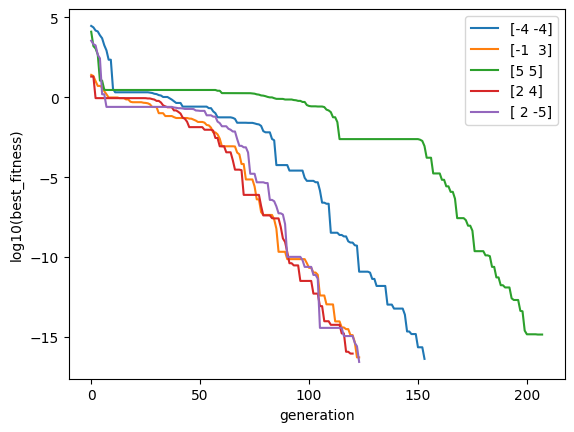

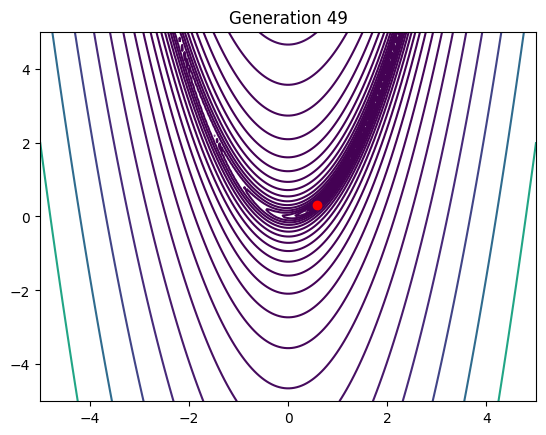

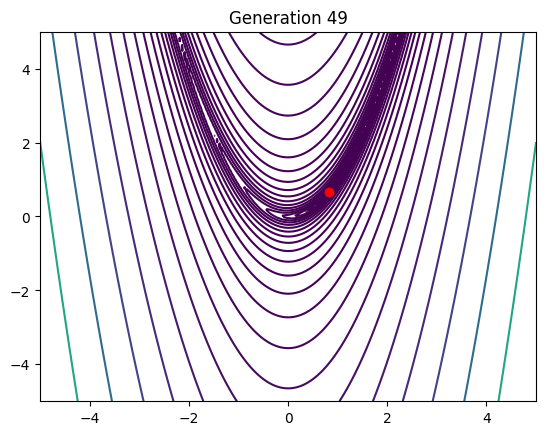

In [60]:
results = []
for x0 in np.array([[-4, -4], [-1, 3], [5, 5], [2, 4], [2, -5]]):
    res = run_cma_es(rosenbrock, x0, 0.5, 250)
    results.append(res)
    plt.plot(np.log10(res.best_fitness), label=str(x0))
    
plt.legend(loc='upper right')
plt.xlabel("generation")
plt.ylabel("log10(best_fitness)")
    
animate_distribution(rosenbrock, results[0].mean_history, results[0].cov_history, filename="ros1.mp4")
animate_distribution(rosenbrock, results[1].mean_history, results[1].cov_history, filename="ros2.mp4") 


If the starting point already has good fitness it takes a little bit more time to get to the minimum.

### Ex. 2: Effect of the Initial Global Step‐Size $\sigma_0$
1. Use [2,2] at starting point on the Rastrigin function.
2. Test $\sigma_0\in\{0.1,\,0.5,\,1,\,2,\,5\}$.
3. Record and plot
- final fitness after a fixed budget (e.g. 1000 evals)
- evolution of es.sigma over time (log scale).
4. Explain why too-small and too-large $\sigma_0$ hurt performance, relating findings to the adaptation rule.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=681436, Tue May  6 11:10:47 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=630520, Tue May  6 11:10:47 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=688472, Tue May  6 11:10:47 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=616655, Tue May  6 11:10:47 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=648609, Tue May  6 11:10:47 2025)
Animation saved to ras1.mp4
Animation saved to ras5.mp4


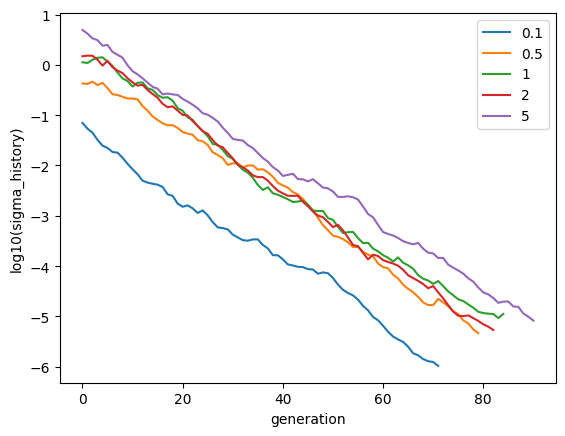

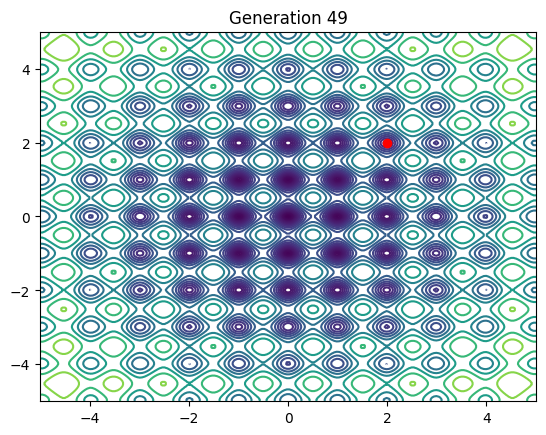

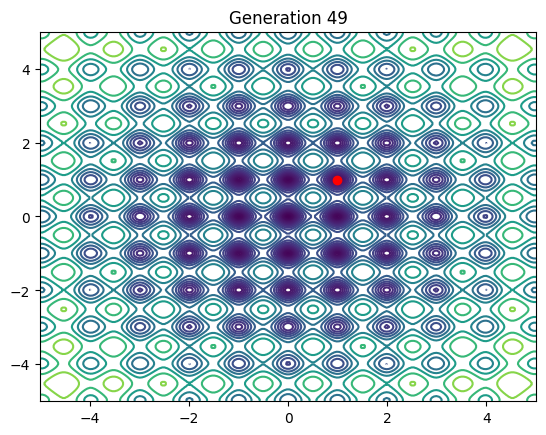

In [62]:
sigmas = [0.1, 0.5, 1, 2, 5]
results = []
for sigma in sigmas:
    result = run_cma_es(rastrigin, np.array([2, 2]), sigma, 1000)
    plt.plot(np.log10(result.sigma_history), label=str(sigma))
    results.append(result)
    
plt.legend(loc='upper right')
plt.xlabel("generation")
plt.ylabel("log10(sigma_history)")

animate_distribution(rastrigin, results[0].mean_history, results[0].cov_history, filename="ras1.mp4")
animate_distribution(rastrigin, results[-1].mean_history, results[-1].cov_history, filename="ras5.mp4") 
    

<BarContainer object of 5 artists>

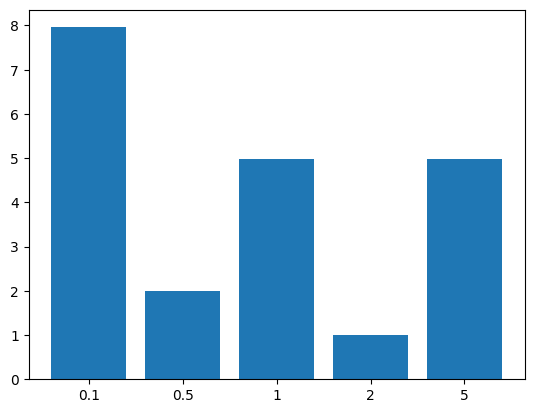

In [51]:
plt.bar([str(s) for s in sigmas], [r.best_fitness[-1] for r in results])

It's an exploration exploitation tradeoff, small sigmas represent the favoring of exploitation while large ones favor exploration. I think Rastrigin generally requires more exploration because of it's structure of lots of local minima, so bigger sigmas can be beneficial here, although too large ones can miss the best solution.

### Ex. 3: Visualising the Covariance Matrix Adaptation
1. On Sphere in 2D, log es.C every 5 generations.
2. Use the provided `animate_distribution` to produce a GIF showing the shrinking and rotation of the sampling ellipse.
3. Submit the animation and two short observations about what the animation reveals regarding step-size vs. shape adaptation.

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=586428, Tue May  6 11:07:15 2025)
Animation saved to sph.mp4
Cov mat at gen 0
[[ 1.09558112 -0.05119138]
 [-0.05119138  0.83007846]]
Cov mat at gen 5
[[ 2.77775039 -0.25668401]
 [-0.25668401  0.37543585]]
Cov mat at gen 10
[[ 0.66440031 -0.00964788]
 [-0.00964788  0.69750063]]
Cov mat at gen 15
[[0.28920599 0.0418017 ]
 [0.0418017  0.18089694]]
Cov mat at gen 20
[[0.11048257 0.03359101]
 [0.03359101 0.09484043]]
Cov mat at gen 25
[[0.03365804 0.00086265]
 [0.00086265 0.02643982]]
Cov mat at gen 30
[[ 0.00973455 -0.00088724]
 [-0.00088724  0.01060549]]
Cov mat at gen 35
[[0.00544289 0.00361866]
 [0.00361866 0.00683737]]
Cov mat at gen 40
[[0.00208672 0.00078784]
 [0.00078784 0.00155172]]
Cov mat at gen 45
[[0.00080843 0.00017537]
 [0.00017537 0.0005603 ]]
Cov mat at gen 50
[[4.63098393e-04 1.04081439e-05]
 [1.04081439e-05 2.75028080e-04]]
Cov mat at gen 55
[[ 1.47131625e-04 -2.79736105e-05]
 [-2.79736105e-05  1.48253891e-04]]
Cov m

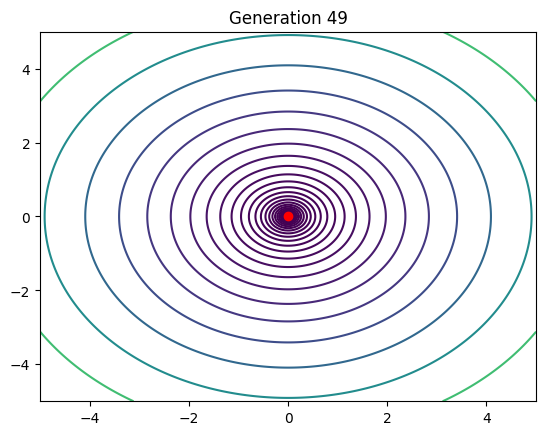

In [59]:
res = run_cma_es(sphere, np.array([-4, -2]), 0.2)
animate_distribution(sphere, res.mean_history, res.cov_history, filename="sph.mp4") 
for i, cov in enumerate(res.cov_history):
    if i % 5 == 0:
        print(f"Cov mat at gen {i}")
        print(cov)

The smaller the steps the smaller the ellipse becomes